# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import base64
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import ( LabelEncoder)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.cluster import DBSCAN
from sklearn.utils import resample
from scipy import stats
from scipy.stats.mstats import winsorize
import warnings
warnings.filterwarnings('ignore')


# Read CSV file

In [2]:
import kagglehub
path = kagglehub.dataset_download("khwaishsaxena/lung-cancer-dataset")
print("Path to dataset files:", path)

100%|██████████| 18.3M/18.3M [00:00<00:00, 148MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/khwaishsaxena/lung-cancer-dataset/versions/1


In [3]:
import os
files_in_directory = os.listdir(path)
print("Files in the downloaded directory:", files_in_directory)

csv_file_name = None
for file in files_in_directory:
    if file.endswith('.csv'):
        csv_file_name = file
        break

if csv_file_name:
    csv_file_path = os.path.join(path, csv_file_name)
    df = pd.read_csv(csv_file_path)
    display(df.head())
else:
    print("No CSV file found in the directory.")



Files in the downloaded directory: ['Lung Cancer.csv']


,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


# Perview the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  890000 non-null  int64  
 1   age                 890000 non-null  float64
 2   gender              890000 non-null  object 
 3   country             890000 non-null  object 
 4   diagnosis_date      890000 non-null  object 
 5   cancer_stage        890000 non-null  object 
 6   family_history      890000 non-null  object 
 7   smoking_status      890000 non-null  object 
 8   bmi                 890000 non-null  float64
 9   cholesterol_level   890000 non-null  int64  
 10  hypertension        890000 non-null  int64  
 11  asthma              890000 non-null  int64  
 12  cirrhosis           890000 non-null  int64  
 13  other_cancer        890000 non-null  int64  
 14  treatment_type      890000 non-null  object 
 15  end_treatment_date  890000 non-nul

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,890000.0,445000.500000,256921.014128,1.0,222500.75,445000.5,667500.25,890000.0
age,890000.0,55.007008,9.994485,4.0,48.00,55.0,62.00,104.0
bmi,890000.0,30.494172,8.368539,16.0,23.30,30.5,37.70,45.0
cholesterol_level,890000.0,233.633916,43.432278,150.0,196.00,242.0,271.00,300.0
hypertension,890000.0,0.750024,0.432999,0.0,1.00,1.0,1.00,1.0
asthma,890000.0,0.469740,0.499084,0.0,0.00,0.0,1.00,1.0
cirrhosis,890000.0,0.225956,0.418211,0.0,0.00,0.0,0.00,1.0
other_cancer,890000.0,0.088157,0.283524,0.0,0.00,0.0,0.00,1.0
survived,890000.0,0.220229,0.414401,0.0,0.00,0.0,0.00,1.0


insight: The most of people do not has other cancer

In [6]:
df.isnull().sum()

,0
id,0
age,0
gender,0
country,0
diagnosis_date,0
cancer_stage,0
family_history,0
smoking_status,0
bmi,0
cholesterol_level,0


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.nunique()

,0
id,890000
age,95
gender,2
country,27
diagnosis_date,3651
cancer_stage,4
family_history,2
smoking_status,4
bmi,291
cholesterol_level,151


In [9]:
print(df['survived'].value_counts(dropna=False))

survived
0    693996
1    196004
Name: count, dtype: int64


In [10]:
df["survival_days"] = (pd.to_datetime(df["end_treatment_date"]) - pd.to_datetime(df["diagnosis_date"])).dt.days

In [11]:
df.drop(['diagnosis_date', 'end_treatment_date','id','other_cancer'], axis=1, inplace=True)

# Encoding

In [12]:
df['family_history'] = df['family_history'].apply(lambda x: 1 if x == 'Yes' else 0)
df.sample()

,age,gender,country,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,treatment_type,survived,survival_days
633824,56.0,Female,Croatia,Stage IV,1,Former Smoker,25.5,168,1,1,0,Chemotherapy,0,442


In [13]:
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
df.sample()

,age,gender,country,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,treatment_type,survived,survival_days
599931,54.0,1,Cyprus,Stage III,0,Current Smoker,37.0,279,1,1,0,Chemotherapy,0,343


In [14]:
stage_mapping = {
    'Stage I': 1,
    'Stage II': 2,
    'Stage III': 3,
    'Stage IV': 4
}
df['cancer_stage'] = df['cancer_stage'].map(stage_mapping)
df.sample()

,age,gender,country,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,treatment_type,survived,survival_days
745214,61.0,0,Hungary,2,0,Never Smoked,29.9,153,1,0,0,Chemotherapy,0,375


In [15]:
df.dtypes

,0
age,float64
gender,int64
country,object
cancer_stage,int64
family_history,int64
smoking_status,object
bmi,float64
cholesterol_level,int64
hypertension,int64
asthma,int64


In [16]:
num_cols = ['age', 'bmi', 'cholesterol_level', 'survival_days']
cat_cols = ['gender', 'country', 'cancer_stage', 'family_history', 'smoking_status',
                    'hypertension', 'asthma', 'cirrhosis','treatment_type', 'survived']

# Visulaize the data

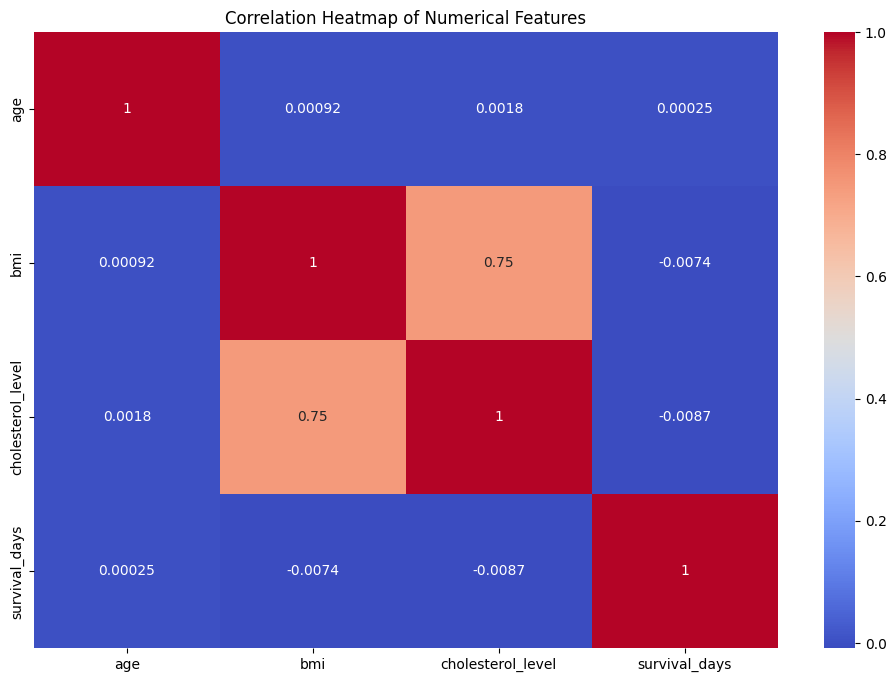

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

insight: to know it is survival or not it is depend on all features

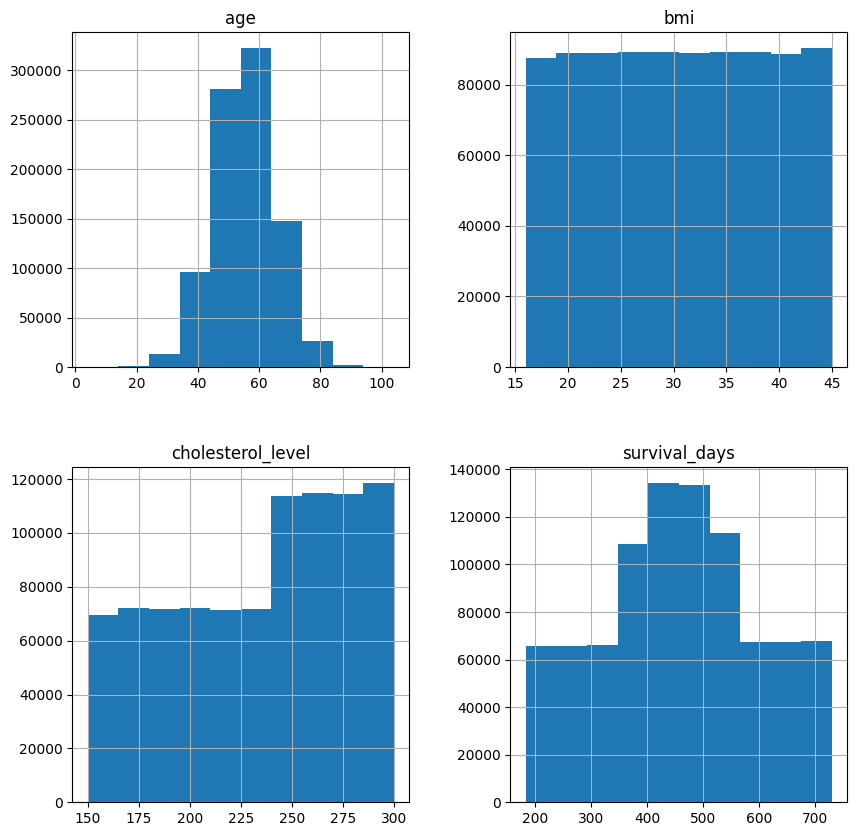

In [18]:
df[['age', 'bmi','cholesterol_level','survival_days']].hist(figsize=(10,10))
plt.show()

insight: between 400 and 500 day of diagnosed the patients death

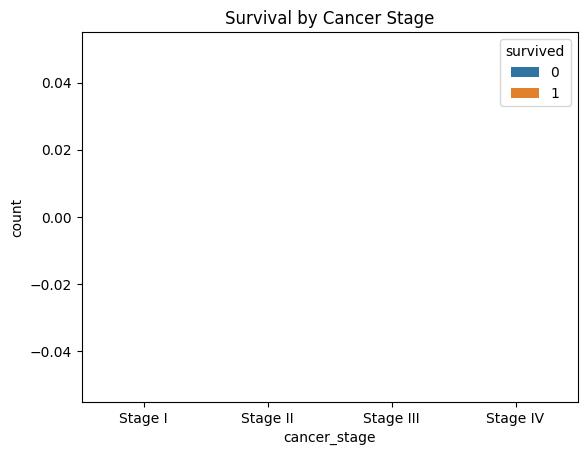

In [19]:
sns.countplot(x='cancer_stage', hue='survived', data=df, order=['Stage I','Stage II','Stage III','Stage IV'])
plt.title("Survival by Cancer Stage")
plt.show()

insight: the satge make a low affect

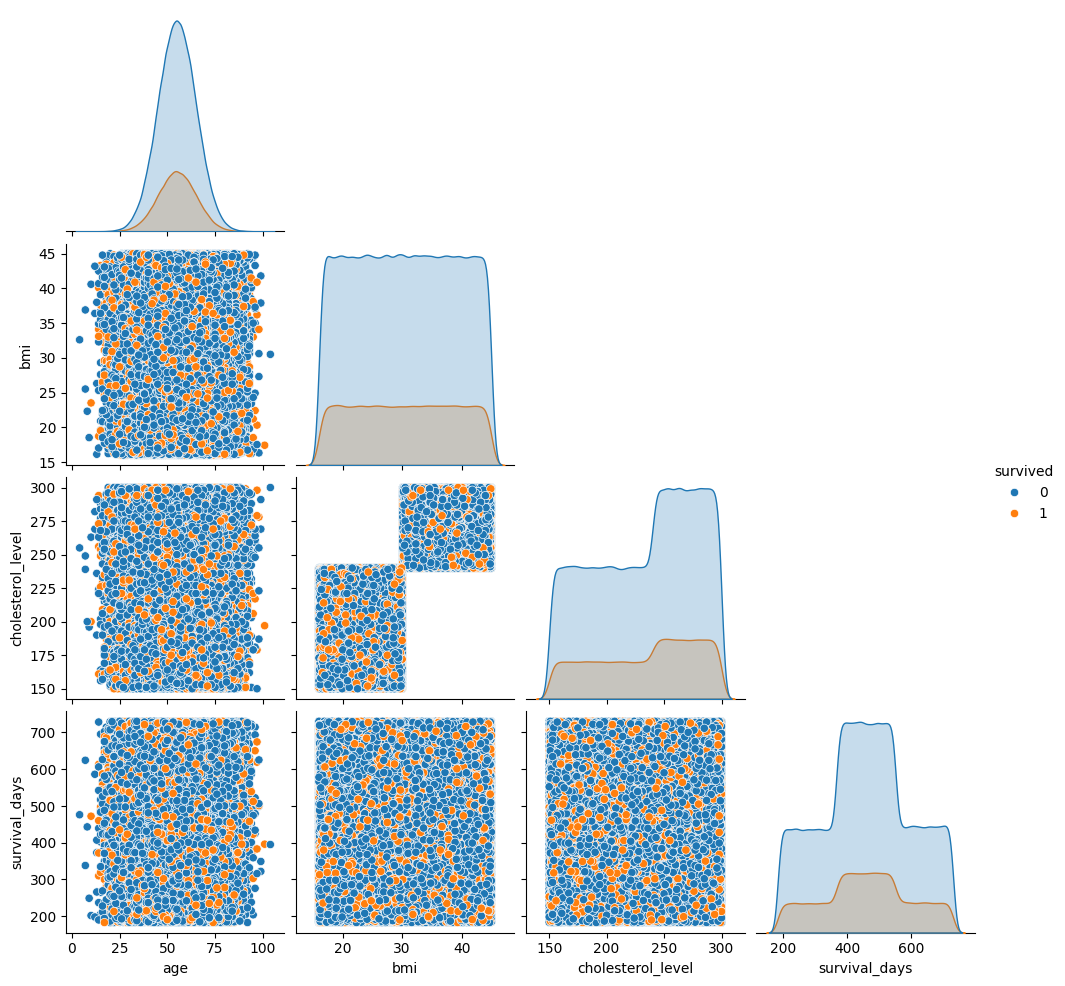

In [20]:
sns.pairplot(df[num_cols + ['survived']], hue="survived", diag_kind="kde", corner=True)
plt.show()

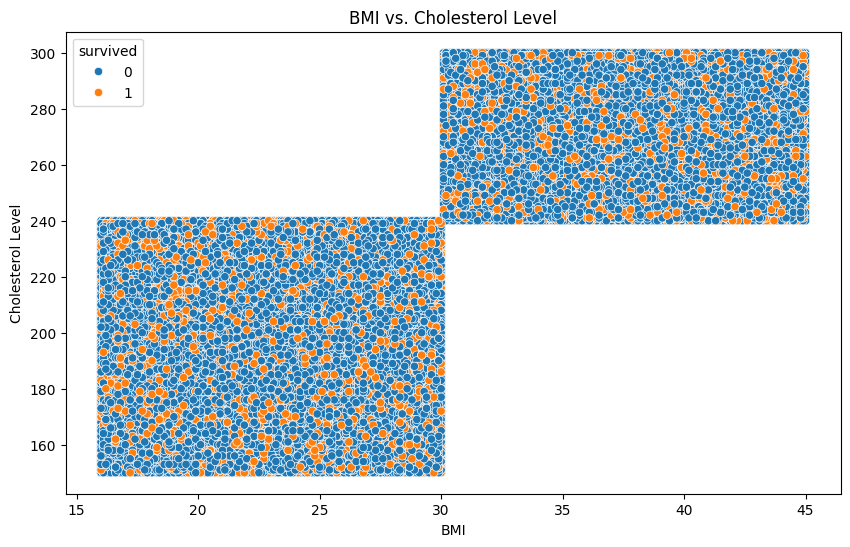

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='bmi', y='cholesterol_level', hue='survived')
plt.title('BMI vs. Cholesterol Level')
plt.xlabel('BMI')
plt.ylabel('Cholesterol Level')
plt.show()

insight: after 30 the cholesterol increase and the max value before it 240

In [22]:
country_stats = df.groupby('country')['survived'].agg(['count', 'mean']).rename(columns={'mean': 'survival_rate'})
top_countries = country_stats.sort_values('count', ascending=False).head(10).reset_index()
top_countries['survival_rate'] = (top_countries['survival_rate'] * 100).round(2)

fig = px.bar(
    top_countries,
    x='country', y='survival_rate', text='survival_rate',
    title='Top 10 Countries by Patient Count and Survival Rate',
    color_discrete_sequence=['#00A896'],
    width=800, height=450
)

fig.update_traces(
    texttemplate='%{text}%',
    textposition='outside',
    marker=dict(line=dict(width=1.5, color='black'))
)
fig.update_layout(
    yaxis_title='Survival Rate (%)',
    xaxis_title='Country',
    title_font_size=20,
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis_range=[0, 100]
)

fig.show()

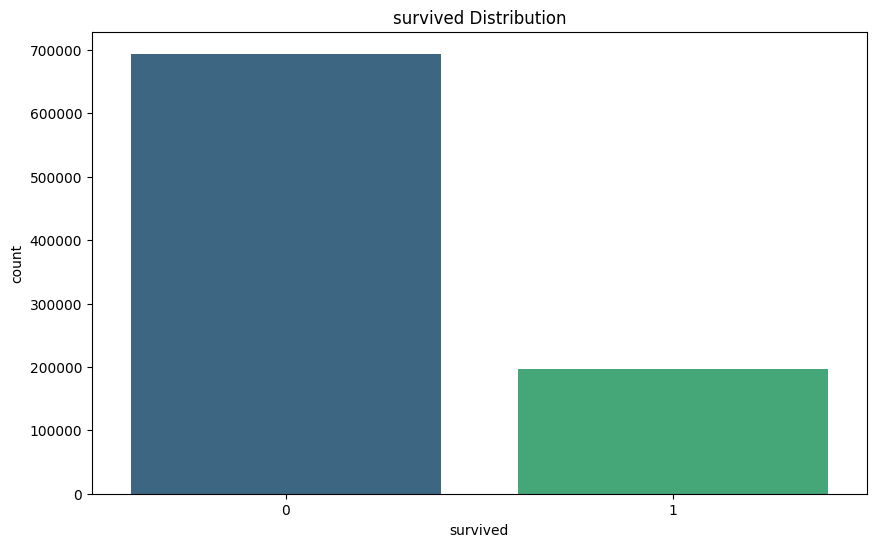

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(x='survived' , data =df , palette = 'viridis')
plt.title('survived Distribution')
plt.show()

### Check the outliers

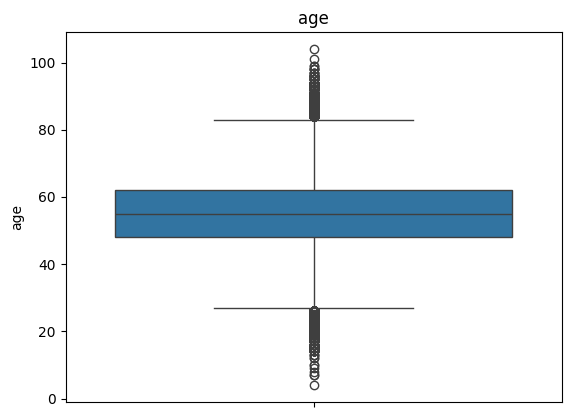

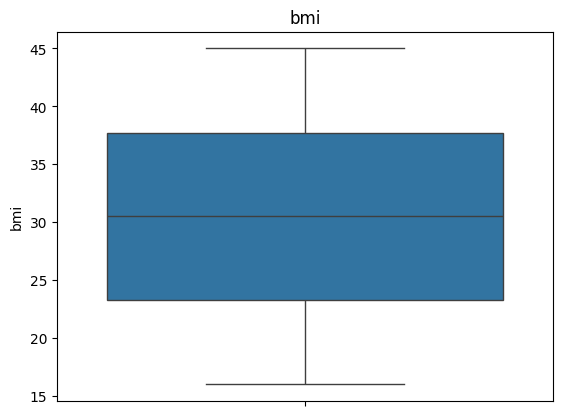

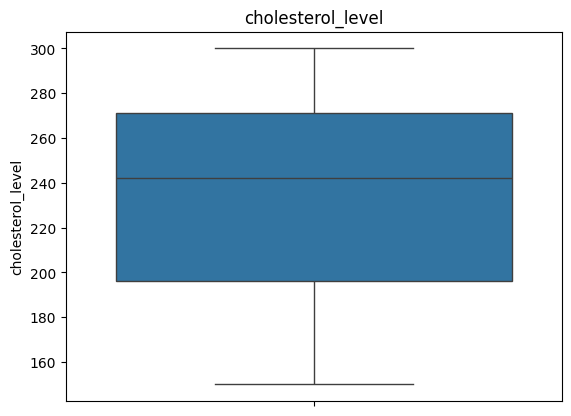

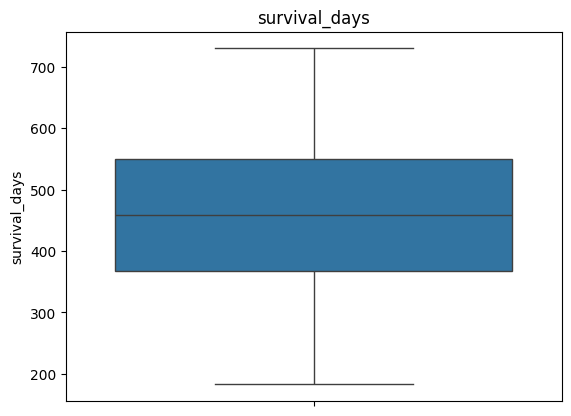

In [24]:
for i in num_cols:
  sns.boxplot(df[i])
  plt.title(i)
  plt.show()

insight: hypertension, astema, critios amd age most affect

# Handling the data

In [25]:
df.drop(['country'], axis=1, inplace=True)

In [26]:
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_cols.remove('country')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
num_imputer = SimpleImputer(strategy='mean')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

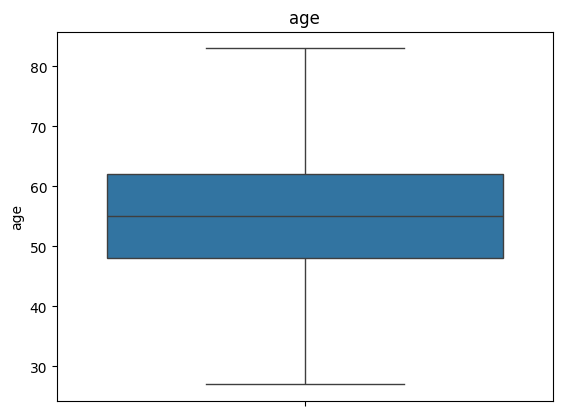

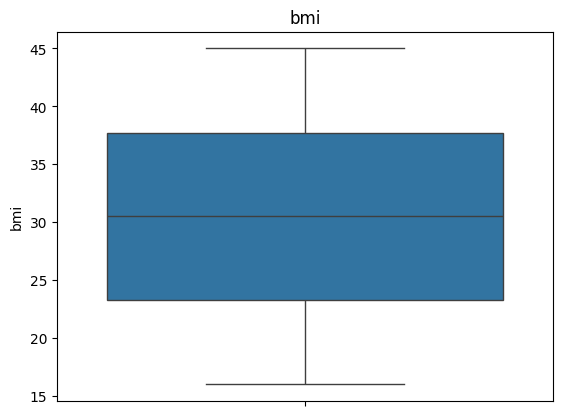

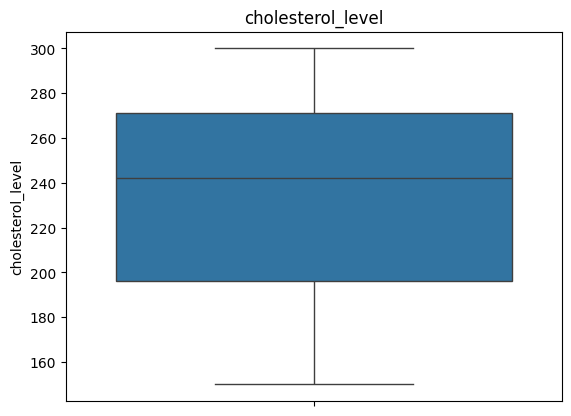

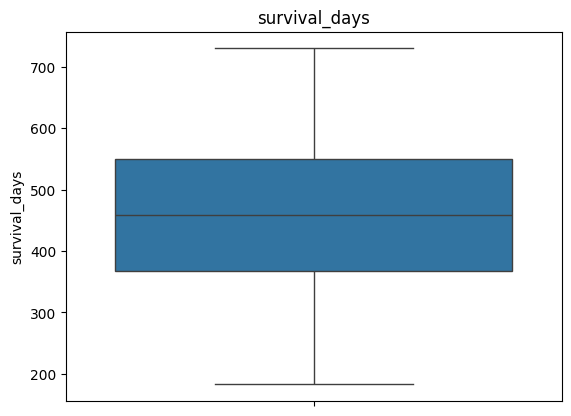

In [27]:
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

for i in num_cols:
  sns.boxplot(df[i])
  plt.title(i)
  plt.show()

In [28]:
label_encoder = LabelEncoder()
df['treatment_type'] = label_encoder.fit_transform(df['treatment_type'])
df['smoking_status'] = label_encoder.fit_transform(df['smoking_status'])


In [29]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV

x = df.drop('survived', axis=1)
y = df['survived'].astype(int)

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(y_train_resampled.value_counts())

Before SMOTE:
survived
0    552783
1    156101
Name: count, dtype: int64

After SMOTE:
survived
0    552783
1    552783
Name: count, dtype: int64


# Modeling

### random forest

In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)
rf.fit(x_train_resampled, y_train_resampled)


y_pred = rf.predict(x_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Survived","Survived"],
            yticklabels=["Not Survived","Survived"])
plt.title("Confusion Matrix - Random Forest")
plt.show()

#  Feature Importance
feat_imp = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance (Random Forest)")
plt.show()

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(x_train_resampled)
X_test = scaler.transform(x_test)

best_k = None
best_score = 0
results = {}

for k in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=k, metric="minkowski", p=2)
    knn.fit(X_train, y_train_resampled)
    y_pred = knn.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[k] = acc

    if acc > best_score:
        best_score = acc
        best_k = k

print("🔹 Accuracy for each k:")
for k, acc in results.items():
    print(f"k={k}: {acc:.4f}")

print("\n✅ Best k:", best_k)
print("✅ Best Accuracy:", best_score)

knn_best = KNeighborsClassifier(n_neighbors=best_k, metric="minkowski", p=2)
knn_best.fit(X_train, y_train_resampled)
y_pred_best = knn_best.predict(X_test)

print("\nClassification Report (Best k):\n", classification_report(y_test, y_pred_best))

### XGboost

In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)


model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


### SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(probability=True)
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(x_train_resampled, y_train_resampled)

y_pred_svm = grid_svm.predict(x_test)

print("Support Vector Machine:")
print(f"Best Params: {grid_svm.best_params_}")
print(f"Best CV Accuracy: {grid_svm.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

cv_acc = grid_svm.best_score_
test_acc = accuracy_score(y_test, y_pred_svm)

plt.figure(figsize=(6,5))
plt.bar(['CV Accuracy', 'Test Accuracy'], [cv_acc, test_acc], color=['violet', 'purple'])
plt.ylim(0, 1)
plt.title('SVM Accuracy')
plt.ylabel('Accuracy')
plt.show()

### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=5000)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(x_train_resampled, y_train_resampled)

y_pred_lr = grid_lr.predict(X_test)

print("Logistic Regression:")
print(f"Best Params: {grid_lr.best_params_}")
print(f"Best CV Accuracy: {grid_lr.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(classification_report(y_test, y_pred_lr))

cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix - Logistic Regression with SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

cv_acc = grid_lr.best_score_
test_acc = accuracy_score(y_test, y_pred_lr)

plt.figure(figsize=(6,5))
plt.bar(['CV Accuracy', 'Test Accuracy'], [cv_acc, test_acc], color=['skyblue', 'orange'])
plt.ylim(0, 1)
plt.title('Logistic Regression Accuracy (with SMOTE)')
plt.ylabel('Accuracy')
plt.show()


### Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=500)
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100,50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

grid_mlp = GridSearchCV(mlp, param_grid_mlp, cv=5, scoring='accuracy', n_jobs=-1)
grid_mlp.fit(x_train_resampled, y_train_resampled)

y_pred_mlp = grid_mlp.predict(X_test)

print("Neural Network (MLP):")
print(f"Best Params: {grid_mlp.best_params_}")
print(f"Best CV Accuracy: {grid_mlp.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
print(classification_report(y_test, y_pred_mlp))

cm = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.title('Confusion Matrix - Neural Network (MLP)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

cv_acc = grid_mlp.best_score_
test_acc = accuracy_score(y_test, y_pred_mlp)

plt.figure(figsize=(6,5))
plt.bar(['CV Accuracy', 'Test Accuracy'], [cv_acc, test_acc], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.title('Neural Network (MLP) Accuracy')
plt.ylabel('Accuracy')
plt.show()